In [1]:
from TCBC_tools import Structure, MachineLearning as ml, FeatureExtraction as fe
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
from scipy.stats import bootstrap
from resample.bootstrap import resample
import numpy as np
from pprint import pprint
from time import perf_counter
warnings.filterwarnings('ignore')
import multiprocessing as mp
import matplotlib.pyplot as plt

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Constants

#Number of rounds to bootstrap
RUNS = 50000

#Meaningful effect size for Cohen's d
MES = 0.79

#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.95

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = Structure.initBooksFromConllus("Conllus_v-1-0")

In [4]:
#Define sub-corpora
"""
ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))
"""

"\nages = sorted(bdf.getAvailableAges(corpus))\n#Generate correct keys/ids\ngroup_1 = [5,6,7,8]\ngroup_2 = [9,10,11,12]\ngroup_3 = [a for a in ages if a>12]\n#Distinct subcorpora\nsub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])\nsub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])\nsub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])\nsub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))\n"

In [5]:
#Prep feature amounts etc. to hopefully speed up calculations
#Old, non-parallelized version
"""
#Data structure will be dict[num,dict[id,dict[feat,value]]]
sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}
index_dict = {}
for sub_corp in sub_corps:
    sub_corp_values = {}
    for book in sub_corps[sub_corp]:
        #If first book, then initialize index_dict that maps indices to features
        if len(index_dict) == 0:
            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)
        #If index_dict already exists, then just fill out the feature vector
        else:
            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])
        #Generate a dictionary that has feature names as keys and feature values as values
        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}
        #Save to sub_corp's dict
        sub_corp_values[book] = book_values
        #Save to sub_corps' dict
    sub_corps_values[sub_corp] = sub_corp_values
"""

"\n#Data structure will be dict[num,dict[id,dict[feat,value]]]\nsub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}\nindex_dict = {}\nfor sub_corp in sub_corps:\n    sub_corp_values = {}\n    for book in sub_corps[sub_corp]:\n        #If first book, then initialize index_dict that maps indices to features\n        if len(index_dict) == 0:\n            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)\n        #If index_dict already exists, then just fill out the feature vector\n        else:\n            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])\n        #Generate a dictionary that has feature names as keys and feature values as values\n        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}\n        #Save to sub_corp's dict\n        sub_corp_values[book] = book_values\n        #Save to sub_corps' dict\n    sub_corps_values[sub_corp] = sub_corp_values\n"

In [6]:
def minMaxNormalization(min_vector: list, max_vector:list, feature_vector:list, ind_to_ignore):
    """
    Helper function for performing min-max normalization for feature vectors
    """
    to_return = []
    for i in range(len(feature_vector)):
        min_max_neg = (max_vector[i]-min_vector[i])
        if min_max_neg == 0 or i in ind_to_ignore:
            to_return.append(0)
        else:
            to_return.append((feature_vector[i]-min_vector[i])/(max_vector[i]-min_vector[i]))
    return to_return


In [7]:
def processBookAndAddToDict(passed_data):
    book_id, book_data = passed_data
    feat_vector = ml.customConlluVectorizer(book_data)
    return (book_id, feat_vector)

In [8]:
#List of items so that we can use map_async
corpus_items = list(corpus.items())

#Generate index dict
temp, index_dict = ml.customConlluVectorizer(list(corpus.values())[0], True)

## Closer look at verb variation and verb variation corrected

In [9]:
def tempVariation(conllu, pos):
    all_pos_tags_present = conllu['upos'].drop_duplicates().to_numpy(str)
    if pos not in all_pos_tags_present:
        return 0
    all_specific_pos = conllu[conllu['upos'] == pos]
    reduced_df = all_specific_pos[['text','upos']]
    return reduced_df
    uniq_words = reduced_df['text'].apply(lambda x: str(x).lower()).drop_duplicates()
    return len(uniq_words) / len(all_specific_pos)


In [10]:
def getConcreteNumbersForVariation(pos):
    total_verb_tokens = {x[0]:len(tempVariation(x[1], pos)) for x in corpus.items()}
    uniq_verb_tokens = {x[0]:len(tempVariation(x[1], pos)['text'].apply(lambda x: str(x).lower()).drop_duplicates()) for x in corpus.items()}
    group_1 = [5,6,7,8]
    group_2 = [9,10,11,12]
    group_3 = [a for a in Structure.getAvailableAges(corpus) if a>12]

    group1_total_verbs = {x[0]:x[1] for x in total_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_1}
    group2_total_verbs = {x[0]:x[1] for x in total_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_2}
    group3_total_verbs = {x[0]:x[1] for x in total_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_3}
    group1_uniq_verbs = {x[0]:x[1] for x in uniq_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_1}
    group2_uniq_verbs = {x[0]:x[1] for x in uniq_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_2}
    group3_uniq_verbs = {x[0]:x[1] for x in uniq_verb_tokens.items() if int(Structure.findAgeFromID(x[0])) in group_3}

    print("Average number of "+pos+" in 7-8: ",np.mean(list(group1_total_verbs.values())))
    print("Average number of "+pos+" in 9-12: ",np.mean(list(group2_total_verbs.values())))
    print("Average number of "+pos+" in 13+: ",np.mean(list(group3_total_verbs.values())))

    print("Average number of unique "+pos+" in 7-8: ",np.mean(list(group1_uniq_verbs.values())))
    print("Average number of unique "+pos+" in 9-12: ",np.mean(list(group2_uniq_verbs.values())))
    print("Average number of unique "+pos+" in 13+: ",np.mean(list(group3_uniq_verbs.values())))

    print("Average "+pos+" variation based on means for 7-8: ",np.mean(list(group1_uniq_verbs.values()))/np.mean(list(group1_total_verbs.values())))
    print("Average "+pos+" variation based on means for 9-12: ",np.mean(list(group2_uniq_verbs.values()))/np.mean(list(group2_total_verbs.values())))
    print("Average "+pos+" variation based on means for 13+: ",np.mean(list(group3_uniq_verbs.values()))/np.mean(list(group3_total_verbs.values())))

In [11]:
#getConcreteNumbersForVariation('VERB')

In [12]:
#getConcreteNumbersForVariation('PRON')

In [13]:
#getConcreteNumbersForVariation('ADV')

In [14]:
#getConcreteNumbersForVariation('SCONJ')

## Raw numbers of past participles

In [15]:
"""
scaled_all_books = fe.getFeatsFeaturePerBook(corpus, 'PartForm=Past', True)
unscaled_all_books = fe.getFeatsFeaturePerBook(corpus, 'PartForm=Past', False)

group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in Structure.getAvailableAges(corpus) if a>12]

group1_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_1}
group2_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_2}
group3_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_3}
group1_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_1}
group2_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_2}
group3_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_3}

print("Average number of past partciciples per sentence in 7-8: ",np.mean(list(group1_scaled_partc.values())))
print("Average number of past partciciples per sentence in 9-12: ",np.mean(list(group2_scaled_partc.values())))
print("Average number of past partciciples per sentence in 13+: ",np.mean(list(group3_scaled_partc.values())))
print("Average number of past partciciples in 7-8: ",np.mean(list(group1_raw_partc.values())))
print("Average number of past partciciples in 9-12: ",np.mean(list(group2_raw_partc.values())))
print("Average number of past partciciples in 13+: ",np.mean(list(group3_raw_partc.values())))
"""

'\nscaled_all_books = fe.getFeatsFeaturePerBook(corpus, \'PartForm=Past\', True)\nunscaled_all_books = fe.getFeatsFeaturePerBook(corpus, \'PartForm=Past\', False)\n\ngroup_1 = [5,6,7,8]\ngroup_2 = [9,10,11,12]\ngroup_3 = [a for a in Structure.getAvailableAges(corpus) if a>12]\n\ngroup1_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_1}\ngroup2_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_2}\ngroup3_scaled_partc = {x[0]:x[1] for x in scaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_3}\ngroup1_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_1}\ngroup2_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_2}\ngroup3_raw_partc = {x[0]:x[1] for x in unscaled_all_books.items() if int(Structure.findAgeFromID(x[0])) in group_3}\n\nprint("Averag

In [16]:
#Function for generating a snippet dataset
def generateSnippetDatasetFromRawConllu(corpus, sniplen):
    returnable = {}
    for book in corpus:
        df = corpus[book]
        new_data = []
        tree = Structure.buildIdTreeFromConllu(df)
        tree_heads = list(tree.keys())
        start = 0
        for i in range(sniplen-1, len(tree), sniplen):
            new_data.append(df.iloc[start:list(tree[tree_heads[i]].keys())[-1]+1])
            start = list(tree[tree_heads[i]].keys())[-1]+1
        returnable[book] = new_data
    return returnable

#group_1_snips = generateSnippetDatasetFromRawConllu({x[0]:x[1] for x in corpus.items() if int(Structure.findAgeFromID(x[0])) in group_1}, 100)
#group_2_snips = generateSnippetDatasetFromRawConllu({x[0]:x[1] for x in corpus.items() if int(Structure.findAgeFromID(x[0])) in group_2}, 100)
#group_3_snips = generateSnippetDatasetFromRawConllu({x[0]:x[1] for x in corpus.items() if int(Structure.findAgeFromID(x[0])) in group_3}, 100)

In [17]:
def snipsTesting(feat):
    group_1_snips_scaled_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]] for x in group_1_snips.items()}
    group_2_snips_scaled_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]]  for x in group_2_snips.items()}
    group_3_snips_scaled_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]]  for x in group_3_snips.items()}
    group_1_snips_raw_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_1_snips.items()}
    group_2_snips_raw_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_2_snips.items()}
    group_3_snips_raw_partc = {x[0]:fe.getFeatsFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_3_snips.items()}

    print("Average number of "+feat+" per sentence in 7-8: ",np.mean(list(group_1_snips_scaled_partc.values())))
    print("Average number of "+feat+" per sentence in 9-12: ",np.mean(list(group_2_snips_scaled_partc.values())))
    print("Average number of "+feat+" per sentence in 13+: ",np.mean(list(group_3_snips_scaled_partc.values())))
    print("Average number of "+feat+" in 7-8: ",np.mean(list(group_1_snips_raw_partc.values())))
    print("Average number of "+feat+" in 9-12: ",np.mean(list(group_2_snips_raw_partc.values())))
    print("Average number of "+feat+" in 13+: ",np.mean(list(group_3_snips_raw_partc.values())))
    print("Std of "+feat+" in 7-8: ",np.std(list(group_1_snips_raw_partc.values())))
    print("Std of "+feat+" in 9-12: ",np.std(list(group_2_snips_raw_partc.values())))
    print("Std of "+feat+" in 13+: ",np.std(list(group_3_snips_raw_partc.values())))

def snipsTesting2(feat):
    group_1_snips_scaled_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]] for x in group_1_snips.items()}
    group_2_snips_scaled_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]]  for x in group_2_snips.items()}
    group_3_snips_scaled_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat, True)[x[0]]  for x in group_3_snips.items()}
    group_1_snips_raw_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_1_snips.items()}
    group_2_snips_raw_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_2_snips.items()}
    group_3_snips_raw_partc = {x[0]:fe.getDeprelFeaturePerBook({x[0]:l for l in x[1]}, feat)[x[0]]  for x in group_3_snips.items()}

    print("Average number of "+feat+" per sentence in 7-8: ",np.mean(list(group_1_snips_scaled_partc.values())))
    print("Average number of "+feat+" per sentence in 9-12: ",np.mean(list(group_2_snips_scaled_partc.values())))
    print("Average number of "+feat+" per sentence in 13+: ",np.mean(list(group_3_snips_scaled_partc.values())))
    print("Average number of "+feat+" in 7-8: ",np.mean(list(group_1_snips_raw_partc.values())))
    print("Average number of "+feat+" in 9-12: ",np.mean(list(group_2_snips_raw_partc.values())))
    print("Average number of "+feat+" in 13+: ",np.mean(list(group_3_snips_raw_partc.values())))
    print("Std of "+feat+" in 7-8: ",np.std(list(group_1_snips_raw_partc.values())))
    print("Std of "+feat+" in 9-12: ",np.std(list(group_2_snips_raw_partc.values())))
    print("Std of "+feat+" in 13+: ",np.std(list(group_3_snips_raw_partc.values())))

In [18]:
#snipsTesting("PartForm=Past")

In [19]:
#snipsTesting("VerbForm=Part")

In [20]:
#snipsTesting2("vocative")

In [21]:
#snipsTesting2("parataxis")

In [22]:
results = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()) as pool:
    with tqdm(total=len(corpus)) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(processBookAndAddToDict, args=(item,), callback=update) for item in corpus_items]
        results = [async_result.get() for async_result in async_results]

100%|██████████| 300/300 [06:13<00:00,  1.25s/it]


## Normalizing data and removing features which are not relevant in less than half of the books

In [23]:
#Normalizing the data
all_values = np.array([x[1] for x in results])

maxs = all_values.max(axis=0)
mins = all_values.min(axis=0)

#"Remove" features which have a presence in less than half of the books
nonz = np.count_nonzero(all_values, axis=0).tolist()

low_feats_counts = {i:nonz[i] for i in range(len(nonz)) if nonz[i]<150}

for i in low_feats_counts:
    print("Ignored feature: ",index_dict[i])


for i in range(len(results)):
    results[i] = (results[i][0], minMaxNormalization(mins, maxs, results[i][1], list(low_feats_counts.keys())))

Ignored feature:  flat
Ignored feature:  goeswith
Ignored feature:  Style=Arch
Ignored feature:  PartForm=Neg
Ignored feature:  Derivation=Tar
Ignored feature:  CCONJ_Phrase
Ignored feature:  SCONJ_Phrase
Ignored feature:  ADP_Phrase
Ignored feature:  PUNCT_Phrase


## Code for checking correlations between variables

['mark', 'ccomp', 'SCONJ']


<Axes: >

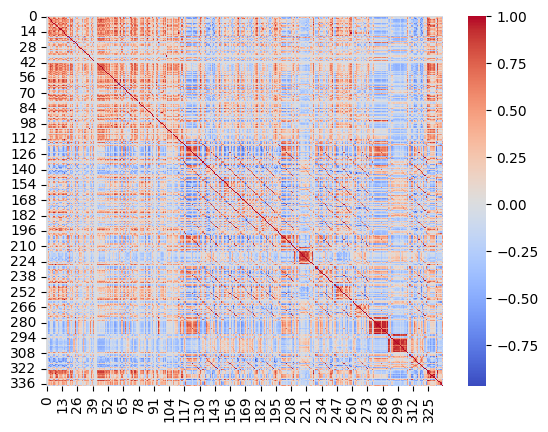

In [24]:
og_results = results.copy()
results = og_results
feat_dict = {index_dict[i]: i for i in index_dict}
all_values = np.array([x[1] for x in results])

corr_coefs = np.nan_to_num(np.corrcoef(all_values, rowvar=False))

strongly_correlating = np.argwhere(corr_coefs[17]>0.9)
strongly_correlating = [index_dict[x[0]] for x in strongly_correlating]
print(strongly_correlating)

sns.heatmap(corr_coefs, cmap='coolwarm')

## PCA testings

## Code for KFA

In [25]:
#Transforming list of items to dicts usable by the code below this block
#Defining subcorpora
ages = sorted(Structure.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= Structure.combineSubCorpDicts([Structure.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= Structure.combineSubCorpDicts([Structure.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= Structure.combineSubCorpDicts([Structure.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))

#Values to a dictionary

sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}

for id, data in results:
    age = int(Structure.findAgeFromID(id))
    if age < 9:
        sub_corps_values['7-8'][id] = {index_dict[x]:data[x] for x in index_dict}
    elif age < 13:
        sub_corps_values['9-12'][id] = {index_dict[x]:data[x] for x in index_dict}
    else:
        sub_corps_values['13+'][id] = {index_dict[x]:data[x] for x in index_dict}

In [26]:
#Using resample's bootstrapping method to gain lists of keys for each subcorp
bootstrapped_books = {j: [x for x in resample(list(sub_corps[j].keys()), size=RUNS)] for j in sub_corps}

In [27]:
#Some helper functions for this notebook
import math
def cohensdForValues(data1: list[float], data2: list[float]) -> float:
    #Sample size
    n1, n2 = len(data1), len(data2)
    #Variance
    s1, s2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
    #Pooled standard deviation
    s = math.sqrt( ((n1-1)*s1 + (n2-1)*s2)/(n1+n2-2) )
    #Return Cohen's d
    return ((np.mean(data1)-np.mean(data2)) / s)

def valueListFromKeys(values, keys, feat):
    return [values[key][feat] for key in keys]

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [28]:
#Old, non-parallelized implementation

effect_sizes_per_run = {}
with tqdm(range(RUNS), desc="Iterating over bootstrapped subcorpora...") as pbar:
    for i in range(RUNS):
        effect_sizes = {}
        for key1 in sub_corps:
            books_1 = bootstrapped_books[key1][i]
            values_1 = sub_corps_values[key1]
            for key2 in sub_corps:
                new_key = str(key1)+" vs. "+str(key2)
                #Skip if we already have the inverse
                if new_key in list(effect_sizes.keys()):
                    continue
                #If keys are the same, then d will be 0 always so save computing time
                if key1 == key2:
                    effect_sizes[new_key] = [0]*len(index_dict)
                    continue
                books_2 = bootstrapped_books[key2][i]
                values_2 = sub_corps_values[key2]
                #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
                effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
                effect_sizes[new_key] = effect_sizes_temp
                #Add the inverse to the dict
                new_key = str(key2)+" vs. "+str(key1)
                effect_sizes[new_key] = effect_sizes_temp * -1
        effect_sizes_per_run[i] = effect_sizes
        pbar.update(1)

Iterating over bootstrapped subcorpora...: 100%|██████████| 50000/50000 [52:40<00:00, 15.82it/s] 


In [29]:
"""
def calcEffectSizes(run_number, sub_corps, bootstrapped_books, sub_corps_values, index_dict):
    effect_sizes = {}
    for key1 in sub_corps:
        books_1 = bootstrapped_books[key1][run_number]
        values_1 = sub_corps_values[key1]
        for key2 in sub_corps:
            new_key = str(key1)+" vs. "+str(key2)
            #Skip if we already have the inverse
            if new_key in list(effect_sizes.keys()):
                continue
            #If keys are the same, then d will be 0 always so save computing time
            if key1 == key2:
                effect_sizes[new_key] = [0]*len(index_dict)
                continue
            books_2 = bootstrapped_books[key2][run_number]
            values_2 = sub_corps_values[key2]
            #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
            effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
            effect_sizes[new_key] = effect_sizes_temp
            #Add the inverse to the dict
            new_key = str(key2)+" vs. "+str(key1)
            effect_sizes[new_key] = effect_sizes_temp * -1
    return (run_number, effect_sizes)
"""

'\ndef calcEffectSizes(run_number, sub_corps, bootstrapped_books, sub_corps_values, index_dict):\n    effect_sizes = {}\n    for key1 in sub_corps:\n        books_1 = bootstrapped_books[key1][run_number]\n        values_1 = sub_corps_values[key1]\n        for key2 in sub_corps:\n            new_key = str(key1)+" vs. "+str(key2)\n            #Skip if we already have the inverse\n            if new_key in list(effect_sizes.keys()):\n                continue\n            #If keys are the same, then d will be 0 always so save computing time\n            if key1 == key2:\n                effect_sizes[new_key] = [0]*len(index_dict)\n                continue\n            books_2 = bootstrapped_books[key2][run_number]\n            values_2 = sub_corps_values[key2]\n            #Oneliner that calculates Cohen\'s d for all feats between bootstrapped subcorps\n            effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(value

In [30]:
#Parallelized version of calculating effect sizes (KFA)
"""
e_s = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()-1) as pool:
    with tqdm(total=RUNS) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(calcEffectSizes, args=(i, sub_corps, bootstrapped_books, sub_corps_values, index_dict), callback=update) for i in range(RUNS)]
        e_s = [async_result.get() for async_result in async_results]
#Combine results together
effect_sizes_per_run = {s[0]:s[1] for s in e_s}
"""

'\ne_s = []\n#Use multiprocessing to speed up vectorizing all books\nwith mp.Pool(mp.cpu_count()-1) as pool:\n    with tqdm(total=RUNS) as pbar:\n        def update(a):\n            pbar.update()\n        async_results = [pool.apply_async(calcEffectSizes, args=(i, sub_corps, bootstrapped_books, sub_corps_values, index_dict), callback=update) for i in range(RUNS)]\n        e_s = [async_result.get() for async_result in async_results]\n#Combine results together\neffect_sizes_per_run = {s[0]:s[1] for s in e_s}\n'

## Finding consistantly meaningful feats according to Cohen's d values over bootstrapped runs

In [31]:
strong_es = 0.8
med_es = 0.5
weak_es = 0.2
CONSISTANT = 0.95

In [32]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeats(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    for corp in ef_sizes:
        y_1 = abs(np.nan_to_num(ef_sizes[corp]))
        for i in index_dict:
            if y_1[i]>=meaningful_ef_size:
                sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

In [33]:
meaningful_feats_strong = []
meaningful_feats_medium = []
meaningful_feats_weak = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        meaningful_feats_strong.append(meaningfulFeats(strong_es, effect_sizes_per_run[i]))
        meaningful_feats_medium.append(meaningfulFeats(med_es, effect_sizes_per_run[i]))
        meaningful_feats_weak.append(meaningfulFeats(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

Calculating meaningful effects per run...: 100%|██████████| 50000/50000 [02:16<00:00, 366.80it/s]


In [34]:
from collections import Counter
import itertools

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
feat_counts_strong = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
feat_counts_medium = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))
feat_counts_weak = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))

Strong ef size:  Counter({'AUX_Variation': 49744, 'ADP_Variation': 48553, 'NOUN_Variation_Corrected': 46899, 'StackingOfClauses': 46416, 'NestingOfClauses': 45279, 'Reflex=Yes': 42910, 'ccomp': 41941, 'ADJ_Variation_Corrected': 41760, 'VERB_Variation': 38905, 'Derivation=Ton': 36474, 'ADV_Variation': 36138, 'MaxTreeDepth': 34847, 'ADV_To_SCONJ_Ratio': 34822, 'SCONJ_To_ADV_Ratio': 34446, 'Number[psor]=Sing': 32188, 'PRON_Variation': 31138, 'TTR': 25673, 'SCONJ_Variation_Corrected': 25367, 'Person[psor]=1': 24094, 'INTJ_To_SCONJ_Ratio': 23622, 'PROPN_To_SCONJ_Ratio': 20056, 'AUX_Variation_Corrected': 16947, 'VERB_Variation_Corrected': 16718, 'ADV_To_AUX_Ratio': 15796, 'Polarity=Neg': 15717, 'AUX_To_ADV_Ratio': 14311, 'PROPN_To_AUX_Ratio': 13017, 'Connegative=Yes': 12498, 'aux': 12142, 'Person=1': 11995, 'Derivation=Vs': 11271, 'Case=Abe': 10819, 'SCONJ_To_CCONJ_Ratio': 10137, 'AUX': 9666, 'INTJ_To_PRON_Ratio': 8454, 'INTJ_To_AUX_Ratio': 8425, 'NOUN_Variation': 8041, 'SCONJ': 7574, 'mark'

In [35]:
#In how big a proportion do feats need to appear in to be considered consistant

consistent_strong_feats = [feat for feat in feat_counts_strong if feat_counts_strong[feat]/RUNS > CONSISTANT]
consistent_medium_feats = [feat for feat in feat_counts_medium if (feat_counts_medium[feat]/RUNS > CONSISTANT) and feat not in consistent_strong_feats]
consistent_weak_feats = [feat for feat in feat_counts_weak if (feat_counts_weak[feat]/RUNS > CONSISTANT) and (feat not in consistent_strong_feats and feat not in consistent_medium_feats)]

In [36]:
"""
temp_dict = {}
for feat in consistent_strong_feats:
    es = []
    index = feat_dict[feat]
    for i in effect_sizes_per_run:
        e = effect_sizes_per_run[i]
        for j in e:
            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:
                es.append(e[j][index])
    temp_dict[feat] = np.array(es)

sns.histplot(temp_dict, legend=False)
"""

"\ntemp_dict = {}\nfor feat in consistent_strong_feats:\n    es = []\n    index = feat_dict[feat]\n    for i in effect_sizes_per_run:\n        e = effect_sizes_per_run[i]\n        for j in e:\n            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:\n                es.append(e[j][index])\n    temp_dict[feat] = np.array(es)\n\nsns.histplot(temp_dict, legend=False)\n"

In [37]:
print("Consistently at least strong features: ",consistent_strong_feats)
print("Consistently at least medium features: ",consistent_medium_feats)
print("Consistently at least weak features: ",consistent_weak_feats)

Consistently at least strong features:  ['AUX_Variation', 'ADP_Variation']
Consistently at least medium features:  ['SCONJ_To_ADV_Ratio', 'PRON_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'SCONJ_Variation_Corrected', 'NestingOfClauses', 'MaxTreeDepth', 'ADJ_Variation_Corrected', 'ccomp', 'PROPN_To_SCONJ_Ratio', 'VERB_Variation_Corrected', 'Derivation=Ton', 'ADV_To_AUX_Ratio', 'NOUN_Variation_Corrected', 'INTJ_To_SCONJ_Ratio', 'ADV_To_SCONJ_Ratio', 'StackingOfClauses', 'Person[psor]=1', 'TTR', 'Reflex=Yes', 'ADV_Variation']
Consistently at least weak features:  ['Style=Coll', 'VERB_To_SCONJ_Ratio', 'PROPN_To_ADJ_Ratio', 'PROPN_To_ADP_Ratio', 'INTJ_To_ADV_Ratio', 'PROPN_To_ADV_Ratio', 'ADP_Variation_Corrected', 'SCONJ_To_PUNCT_Ratio', 'Degree=Pos', 'AUX_To_ADJ_Ratio', 'Number=Sing', 'NUM_Variation_Corrected', 'PRON_To_SCONJ_Ratio', 'vocative', 'SCONJ', 'cop', 'AUX_Variation_Corrected', 'compound:nn', 'PRON_To_NUM_Ratio', 'PronType=Prs', 'obj', 'VerbForm=Inf', 'Polarity=Neg', 'para

In [77]:
means = {}
for j in range(9):
    for i in effect_sizes_per_run:
        to_mean = []
        es = effect_sizes_per_run[i]
        to_mean.append(np.nan_to_num(np.array(list(es.values())[j])))
    means[list(es.keys())[j]] = np.mean(to_mean, axis=0)

In [90]:
ef_df = pd.DataFrame(means, index=list(index_dict.values()))
testing_df = ef_df.copy()
print(len(testing_df))
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']

#Choose one of the ones below to use for the visualizations. Either Strong+, Medium+, or Weak+ feats

#most_important = consistent_strong_feats
most_important = consistent_strong_feats+consistent_medium_feats
#most_important = [x for x in consistent_medium_feats+consistent_weak_feats if (x.find('Derivation') != -1 or x.find('Case') != -1)]
to_drop = [x for x in index_dict.values() if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop).sort_values(['7-8 vs. 9-12'], ascending=False)
print(len(testing_df_edited))

338
['AUX_Variation', 'ADP_Variation', 'SCONJ_To_ADV_Ratio', 'PRON_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'SCONJ_Variation_Corrected', 'NestingOfClauses', 'MaxTreeDepth', 'ADJ_Variation_Corrected', 'ccomp', 'PROPN_To_SCONJ_Ratio', 'VERB_Variation_Corrected', 'Derivation=Ton', 'ADV_To_AUX_Ratio', 'NOUN_Variation_Corrected', 'INTJ_To_SCONJ_Ratio', 'ADV_To_SCONJ_Ratio', 'StackingOfClauses', 'Person[psor]=1', 'TTR', 'Reflex=Yes', 'ADV_Variation']
23


In [91]:
print(len(consistent_strong_feats)+len(consistent_medium_feats)+len(consistent_weak_feats))

136


<Axes: >

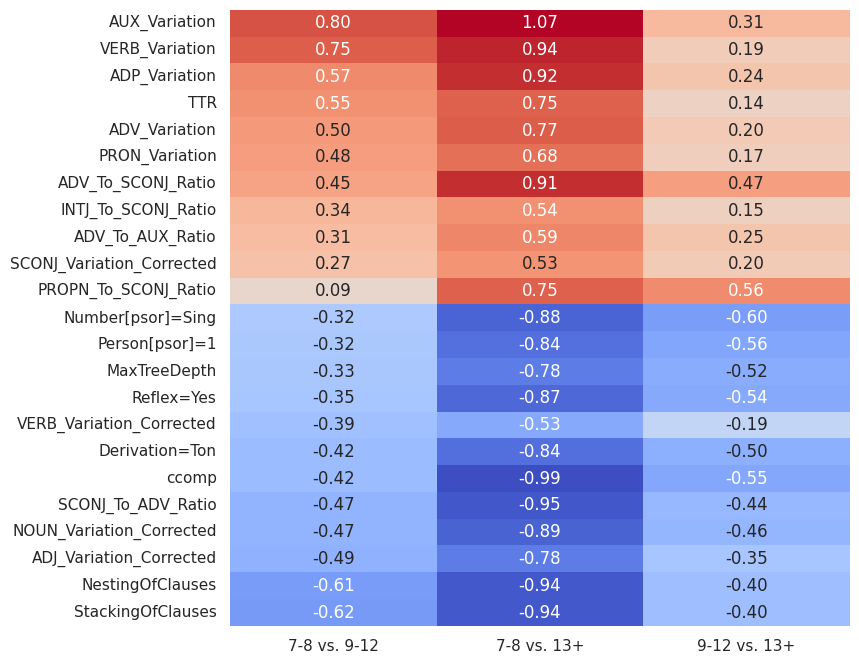

In [92]:
plt.figure(figsize=(8,8))
sns.set_theme(font_scale=1)
sns.heatmap(testing_df_edited[['7-8 vs. 9-12', '7-8 vs. 13+', '9-12 vs. 13+']], cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, annot=True, yticklabels=testing_df_edited.index.to_list(), cbar=False)

## Table including ALL features in Weak+, Medium+, and Strong+

<Axes: >

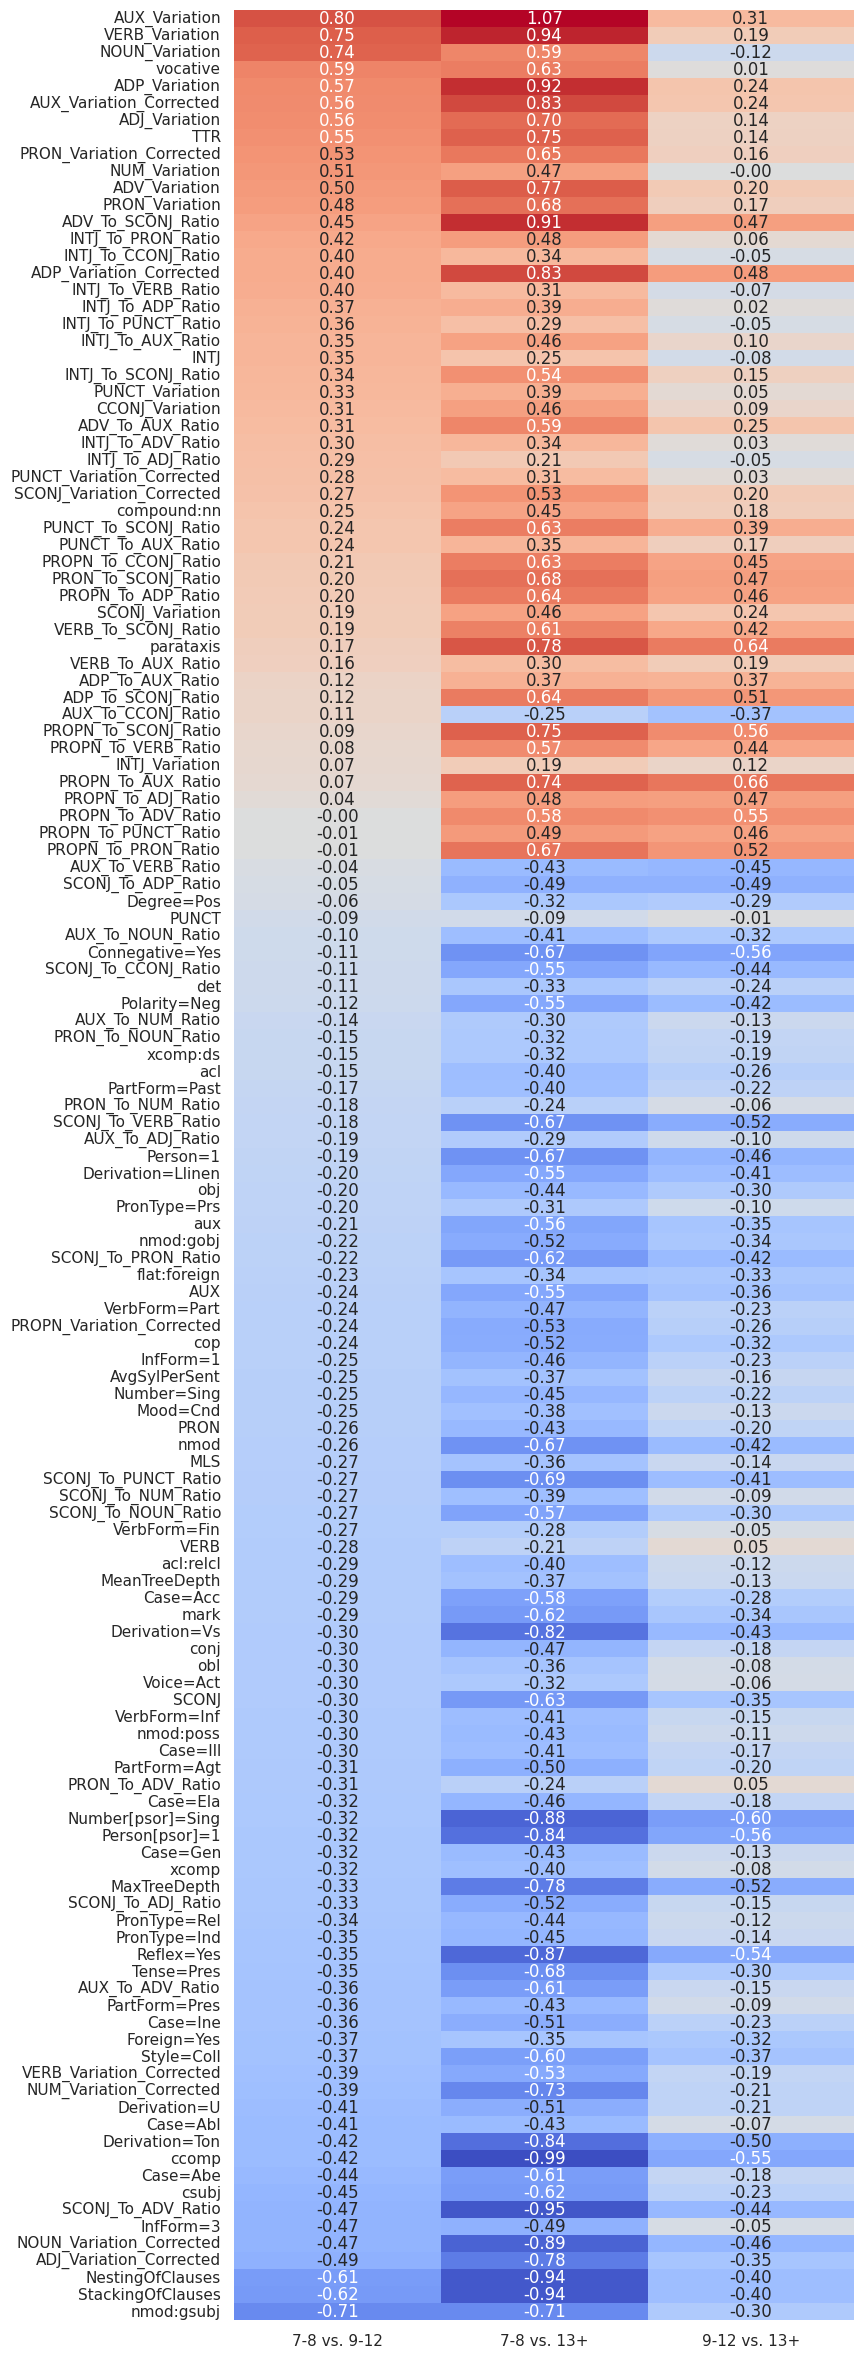

In [86]:
plt.figure(figsize=(8,30))
most_important_2 = consistent_strong_feats+consistent_medium_feats+consistent_weak_feats
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
testing_df_edited_2 = testing_df.drop(to_drop_2).sort_values(['7-8 vs. 9-12'], ascending=False)
sns.heatmap(testing_df_edited_2[['7-8 vs. 9-12', '7-8 vs. 13+', '9-12 vs. 13+']], cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, annot=True, yticklabels=testing_df_edited_2.index.to_list(), cbar=False)

In [43]:
to_drop = [x for x in index_dict.values() if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop).sort_values(['7-8 vs. 9-12'], ascending=False)

['AUX_Variation', 'ADP_Variation', 'SCONJ_To_ADV_Ratio', 'PRON_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'SCONJ_Variation_Corrected', 'NestingOfClauses', 'MaxTreeDepth', 'ADJ_Variation_Corrected', 'ccomp', 'PROPN_To_SCONJ_Ratio', 'VERB_Variation_Corrected', 'Derivation=Ton', 'ADV_To_AUX_Ratio', 'NOUN_Variation_Corrected', 'INTJ_To_SCONJ_Ratio', 'ADV_To_SCONJ_Ratio', 'StackingOfClauses', 'Person[psor]=1', 'TTR', 'Reflex=Yes', 'ADV_Variation']


## Other visualizations not in the paper

<Axes: >

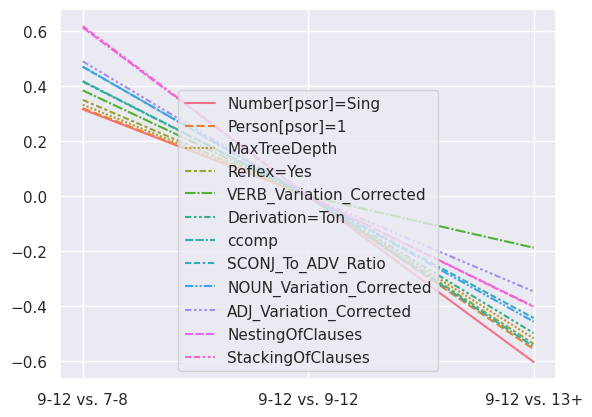

In [44]:
red_df = testing_df_edited[sub_columns(ef_df.columns, '9')]

sns.lineplot(red_df[red_df[red_df.columns[0]] > 0].transpose())

<Axes: >

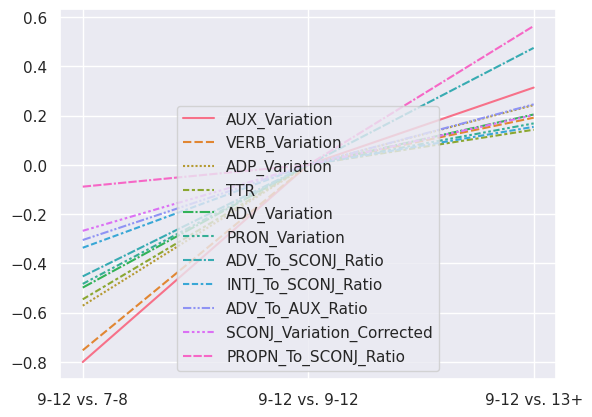

In [45]:
sns.lineplot(red_df[red_df[red_df.columns[0]] < 0].transpose())

## Plot KFA results distributions and compare with different feature sets

In [46]:
def plotKFAValuesDistribution(effect_sizes_per_run, chosen_comp, weak_feat_indices, medium_feat_indices, strong_feat_indices):
    """
    Helper function for plotting histogram distribution of KFA results.
    Optionally you can add a subset of features (their indices from index_dict) to e.g. only include features with consitently strong effects.
    The red lines mark the area where effect sizes are not significant
    """

    f, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True)

    all_vals = []
    weak_vals = []
    medium_vals = []
    strong_vals = []
    for i in effect_sizes_per_run:
            weak_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in weak_feat_indices]
            medium_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in medium_feat_indices]
            strong_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in strong_feat_indices]
            all_vals += effect_sizes_per_run[i][chosen_comp].tolist()
    sns.histplot(all_vals, ax=axes[0], bins=500, color='#049BE5')
    axes[0].set_title('All features')
    sns.histplot(weak_vals, ax=axes[3], bins=500, color='#049BE5')
    axes[1].set_title('Weak+ features')
    sns.histplot(medium_vals, ax=axes[2], bins=500, color='#049BE5')
    axes[2].set_title('Medium+ features')
    sns.histplot(strong_vals, ax=axes[1], bins=500, color='#049BE5')
    axes[3].set_title('Strong+ features')
    for a in range(4):
          axes[a].axvline(weak_es, 0, 15000, color='#E54E04')
          axes[a].axvline(-weak_es, 0, 15000, color='#E54E04')
          axes[a].set_xlim(-1.2, 1.2)
          axes[a].set_yticks([])
          axes[a].set_ylabel("")

In [47]:
cons_strong_indices = [feat_dict[feat] for feat in consistent_strong_feats]
cons_med_indices = [feat_dict[feat] for feat in consistent_medium_feats]
cons_weak_indices = [feat_dict[feat] for feat in consistent_weak_feats]

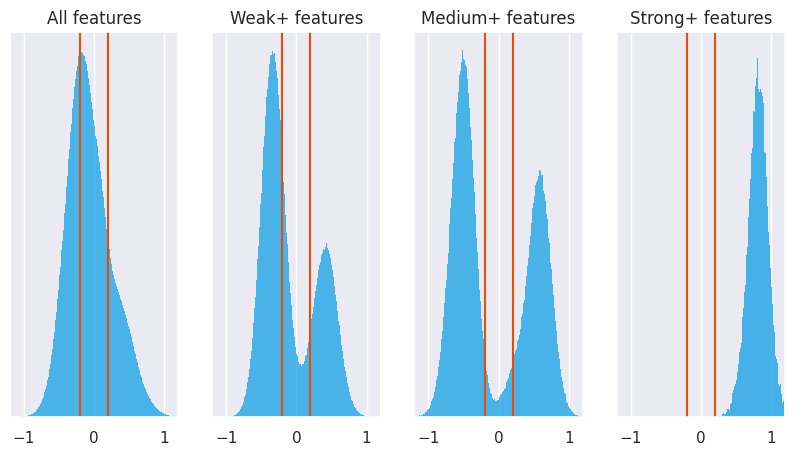

In [48]:
# 7-8 vs. 9-12
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 9-12', cons_strong_indices, cons_med_indices, cons_weak_indices)

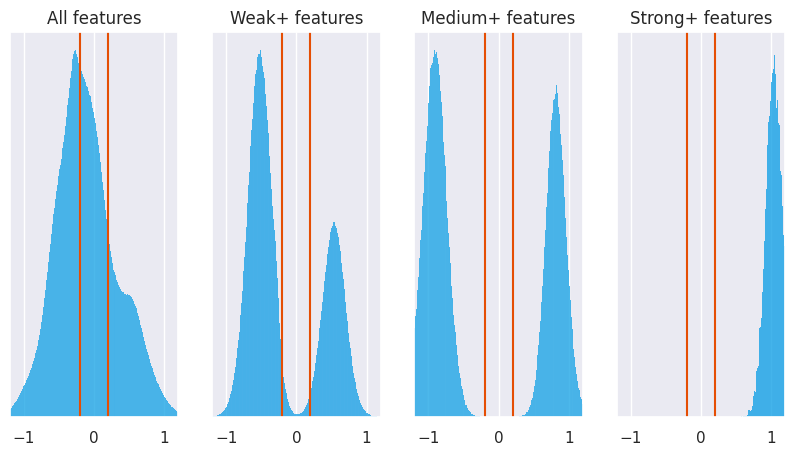

In [49]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

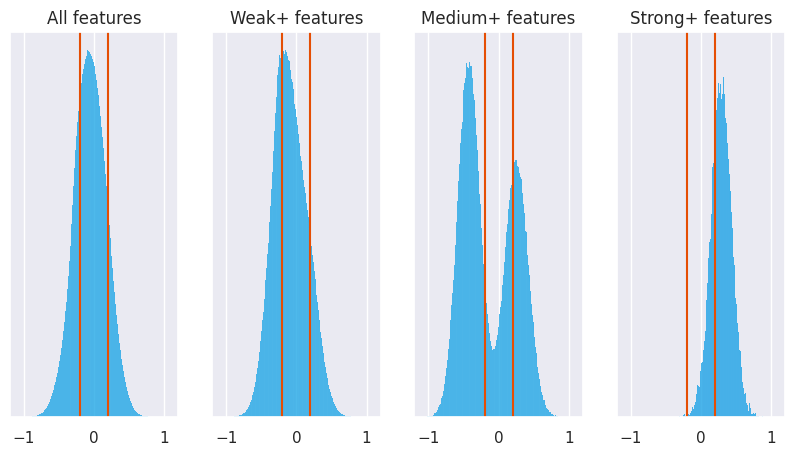

In [50]:
# 9-12 vs. 13+
plotKFAValuesDistribution(effect_sizes_per_run, '9-12 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

## Additional look at differentiating features between 7-8 and 9-12

In [51]:
chosen_comparison = '7-8 vs. 9-12'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT and feat not in c_s_f]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT and feat not in c_s_f and feat not in c_m_f]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)



Calculating meaningful effects per run...: 100%|██████████| 50000/50000 [00:05<00:00, 9712.28it/s] 


Strong ef size:  Counter({'AUX_Variation': 33340, 'ADP_Variation': 21808, 'VERB_Variation': 11835, 'ADV_Variation': 10052, 'NestingOfClauses': 7624, 'NOUN_Variation': 7090, 'INTJ_To_SCONJ_Ratio': 6647, 'StackingOfClauses': 6227, 'ADJ_Variation_Corrected': 6063, 'NOUN_Variation_Corrected': 4184, 'PRON_Variation': 4146, 'NUM_Variation': 3581, 'TTR': 3243, 'INTJ_To_PRON_Ratio': 2699, 'AUX_Variation_Corrected': 2443, 'SCONJ_Variation_Corrected': 1973, 'PRON_Variation_Corrected': 1856, 'SCONJ_To_ADV_Ratio': 1639, 'MaxTreeDepth': 1564, 'INTJ_To_AUX_Ratio': 1084, 'INTJ_To_ADV_Ratio': 1018, 'ccomp': 1000, 'VERB_Variation_Corrected': 999, 'ADV_To_SCONJ_Ratio': 964, 'vocative': 857, 'InfForm=3': 825, 'Case=Abl': 726, 'Case=Abe': 725, 'ADJ_Variation': 654, 'csubj': 600, 'PROPN_To_ADP_Ratio': 521, 'CCONJ_Variation': 517, 'Derivation=Ton': 506, 'INTJ_To_CCONJ_Ratio': 496, 'nmod:gsubj': 495, 'INTJ_To_PUNCT_Ratio': 473, 'PronType=Rel': 398, 'Case=Ine': 389, 'Tense=Pres': 348, 'PROPN_To_SCONJ_Ratio': 

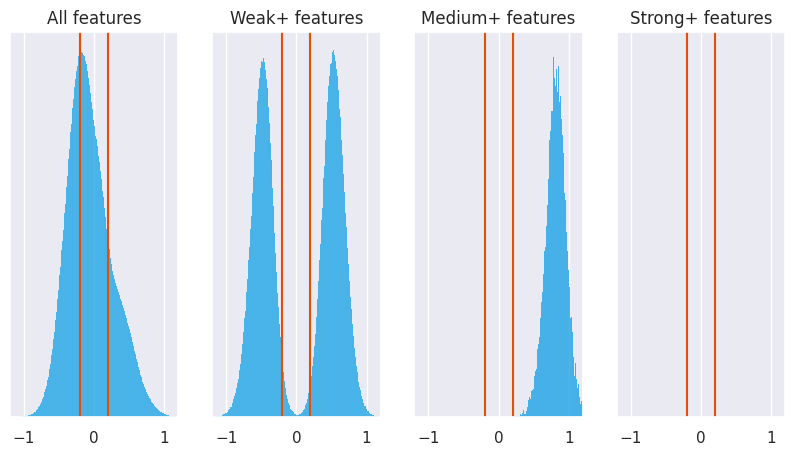

In [52]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

338
['Style=Coll', 'SCONJ_To_ADV_Ratio', 'PROPN_To_ADP_Ratio', 'PRON_Variation', 'INTJ_To_ADV_Ratio', 'VERB_Variation', 'vocative', 'AUX_Variation_Corrected', 'VerbForm=Inf', 'INTJ_To_AUX_Ratio', 'PartForm=Pres', 'InfForm=1', 'NOUN_Variation', 'SCONJ_Variation_Corrected', 'NestingOfClauses', 'MaxTreeDepth', 'ADJ_Variation_Corrected', 'INTJ_To_ADP_Ratio', 'INTJ_To_VERB_Ratio', 'PronType=Ind', 'Case=Abl', 'PROPN_To_CCONJ_Ratio', 'ccomp', 'NUM_Variation', 'VERB_Variation_Corrected', 'Derivation=Ton', 'Derivation=Llinen', 'Case=Ine', 'Case=Abe', 'ADJ_Variation', 'PRON_Variation_Corrected', 'NOUN_Variation_Corrected', 'INTJ_To_SCONJ_Ratio', 'SCONJ_Variation', 'INTJ_To_CCONJ_Ratio', 'ADV_To_SCONJ_Ratio', 'StackingOfClauses', 'INTJ_To_PUNCT_Ratio', 'INTJ_To_PRON_Ratio', 'PronType=Rel', 'nmod:gsubj', 'InfForm=3', 'TTR', 'Reflex=Yes', 'ADV_Variation']
45


<Axes: >

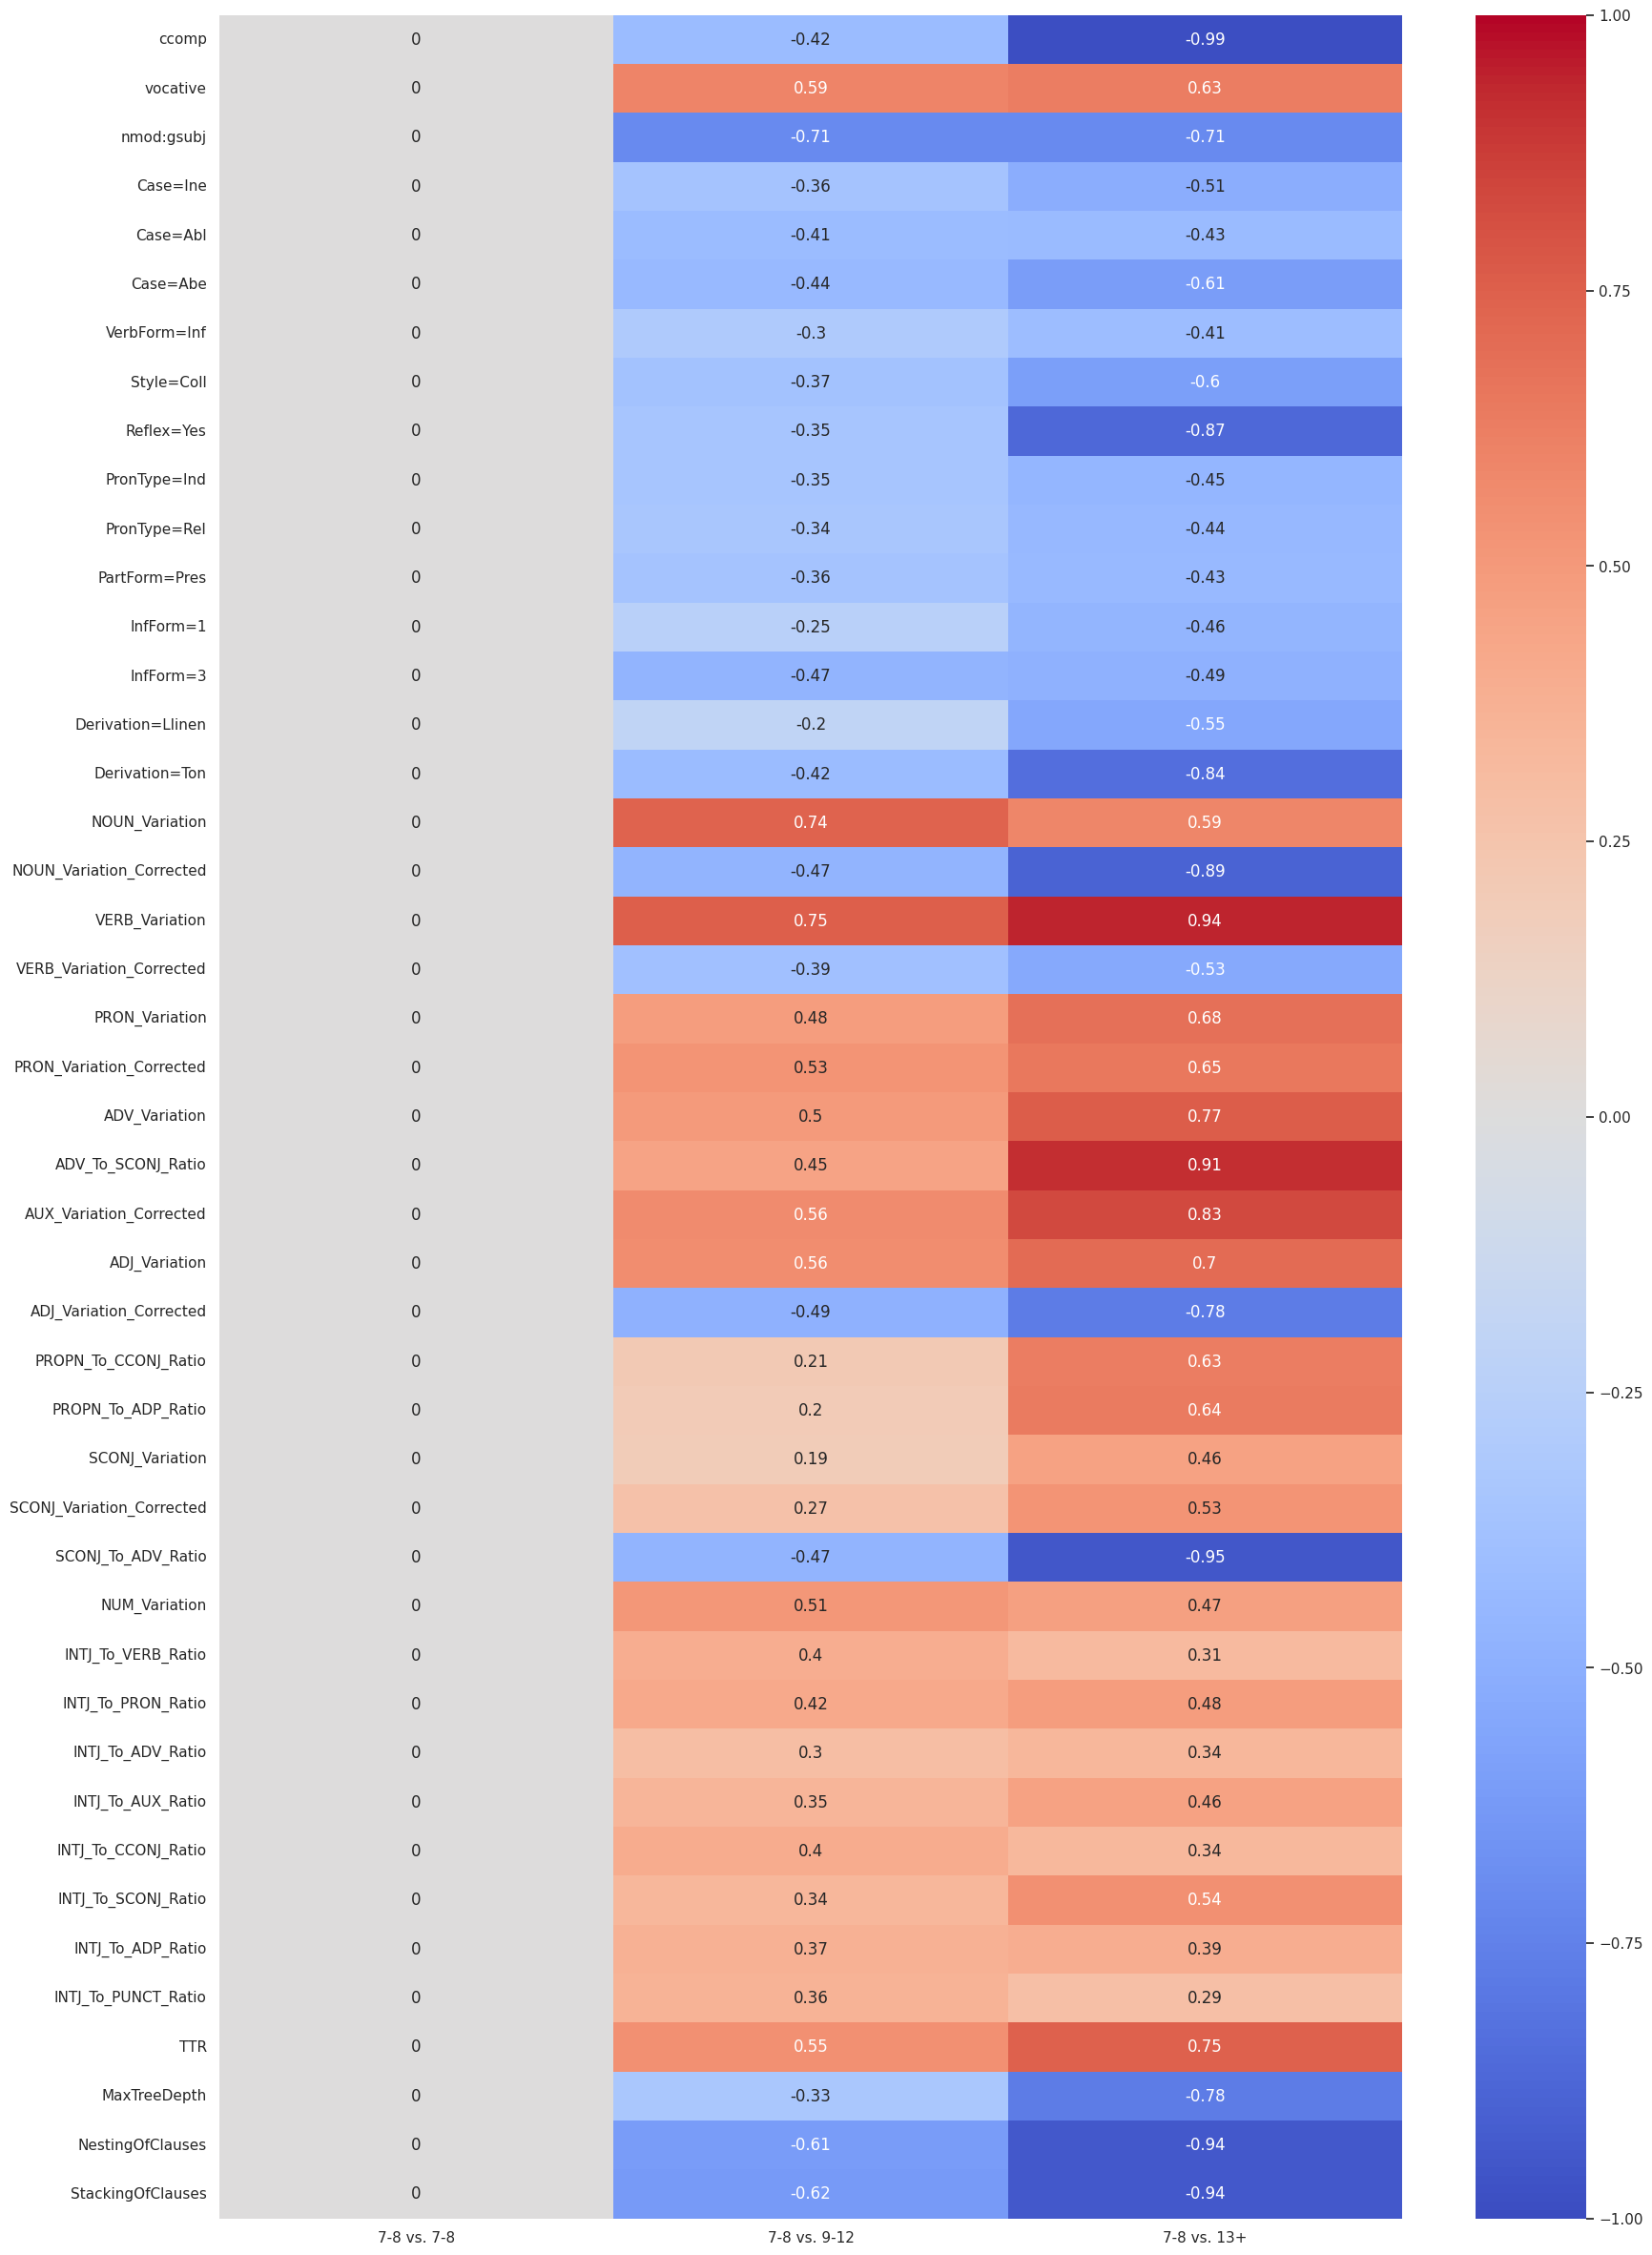

In [53]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
#most_important_2 = c_m_f
most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
plt.figure(figsize=(20,30))
sns.set_theme(font_scale=1)
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Additional look at differentiating features between 7-8 and 13+

In [54]:
chosen_comparison = '7-8 vs. 13+'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)



Calculating meaningful effects per run...: 100%|██████████| 50000/50000 [00:05<00:00, 8809.26it/s] 


Strong ef size:  Counter({'AUX_Variation': 49723, 'ADP_Variation': 48331, 'NOUN_Variation_Corrected': 46878, 'StackingOfClauses': 46405, 'NestingOfClauses': 45258, 'Reflex=Yes': 42902, 'ccomp': 41937, 'ADJ_Variation_Corrected': 41582, 'VERB_Variation': 38341, 'Derivation=Ton': 36466, 'ADV_Variation': 35002, 'MaxTreeDepth': 34829, 'ADV_To_SCONJ_Ratio': 34806, 'SCONJ_To_ADV_Ratio': 34405, 'Number[psor]=Sing': 32178, 'PRON_Variation': 30617, 'TTR': 25186, 'SCONJ_Variation_Corrected': 24918, 'Person[psor]=1': 24053, 'INTJ_To_SCONJ_Ratio': 22134, 'PROPN_To_SCONJ_Ratio': 20033, 'AUX_Variation_Corrected': 16717, 'VERB_Variation_Corrected': 16450, 'ADV_To_AUX_Ratio': 15764, 'Polarity=Neg': 15649, 'AUX_To_ADV_Ratio': 14290, 'PROPN_To_AUX_Ratio': 13005, 'Connegative=Yes': 12449, 'aux': 12119, 'Person=1': 11977, 'Derivation=Vs': 11183, 'Case=Abe': 10716, 'SCONJ_To_CCONJ_Ratio': 10087, 'AUX': 9620, 'INTJ_To_AUX_Ratio': 7958, 'SCONJ': 7478, 'mark': 7163, 'INTJ_To_PRON_Ratio': 7063, 'SCONJ_To_NOUN_R

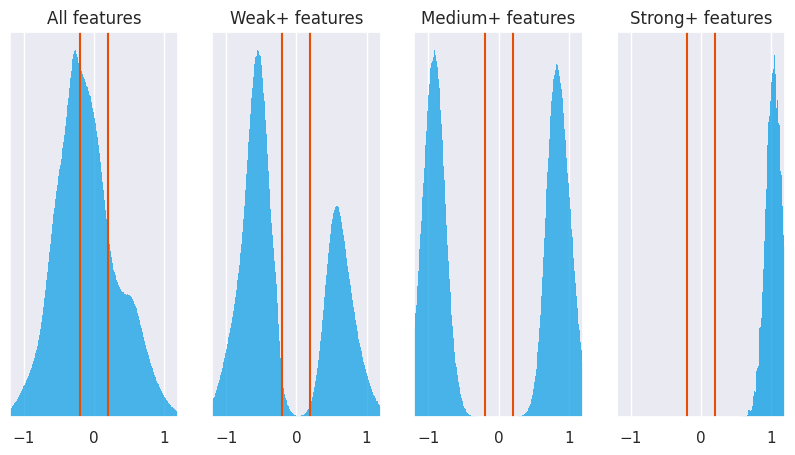

In [55]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

338
['SCONJ_To_ADV_Ratio', 'PRON_Variation', 'VERB_Variation', 'ADP_Variation', 'AUX_Variation', 'Number[psor]=Sing', 'SCONJ_Variation_Corrected', 'NestingOfClauses', 'MaxTreeDepth', 'ADJ_Variation_Corrected', 'ccomp', 'PROPN_To_SCONJ_Ratio', 'Derivation=Ton', 'ADV_To_AUX_Ratio', 'NOUN_Variation_Corrected', 'INTJ_To_SCONJ_Ratio', 'ADV_To_SCONJ_Ratio', 'StackingOfClauses', 'Person[psor]=1', 'TTR', 'Reflex=Yes', 'ADV_Variation']
22


<Axes: >

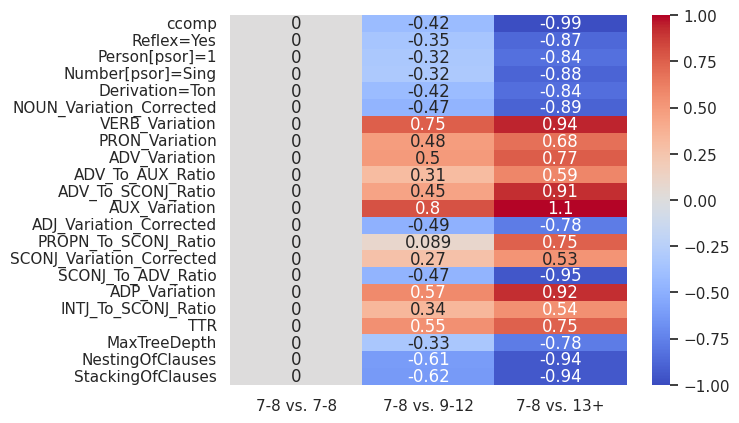

In [56]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
most_important_2 = c_m_f
#most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Additional look at differentiating features between 9-12 and 13+

In [57]:
chosen_comparison = '9-12 vs. 13+'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)

Calculating meaningful effects per run...: 100%|██████████| 50000/50000 [00:04<00:00, 10370.52it/s]


Strong ef size:  Counter({'StackingOfClauses': 1046, 'NOUN_Variation_Corrected': 977, 'Reflex=Yes': 908, 'Number[psor]=Sing': 753, 'Polarity=Neg': 698, 'Person[psor]=1': 613, 'Derivation=Ton': 311, 'ADJ_Variation_Corrected': 266, 'Connegative=Yes': 260, 'NestingOfClauses': 248, 'Derivation=Vs': 212, 'ADV_To_AUX_Ratio': 196, 'MaxTreeDepth': 165, 'ccomp': 157, 'Person=1': 150, 'ADP_To_AUX_Ratio': 118, 'AUX_To_NOUN_Ratio': 115, 'AUX_To_ADP_Ratio': 100, 'aux': 86, 'AUX_To_ADV_Ratio': 78, 'AUX': 77, 'AUX_To_VERB_Ratio': 77, 'AUX_To_CCONJ_Ratio': 61, 'PROPN_To_AUX_Ratio': 47, 'SCONJ_To_ADP_Ratio': 29, 'SCONJ_To_ADV_Ratio': 27, 'obj': 26, 'AUX_Variation': 26, 'ADV_To_SCONJ_Ratio': 24, 'PartForm=Past': 22, 'VerbForm=Part': 22, 'Derivation=Ja': 11, 'SCONJ_To_CCONJ_Ratio': 11, 'ADP_To_SCONJ_Ratio': 10, 'csubj:cop': 10, 'ADP_To_PUNCT_Ratio': 8, 'ADJ_To_NOUN_Ratio': 8, 'Degree=Pos': 8, 'cop': 7, 'Number=Sing': 7, 'ADJ_Phrase': 7, 'flat:foreign': 6, 'PROPN_To_SCONJ_Ratio': 6, 'parataxis': 6, 'AUX_T

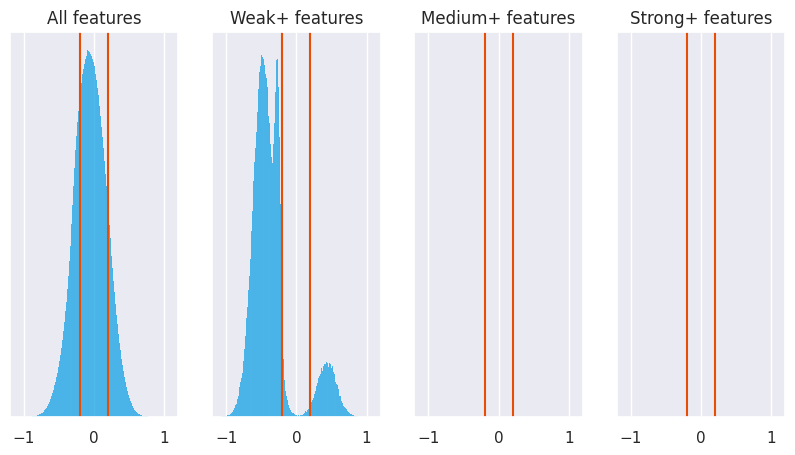

In [58]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

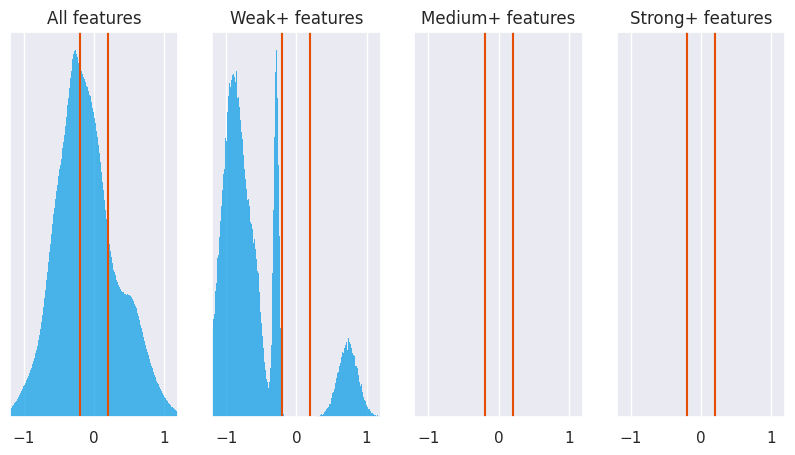

In [59]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 13+', c_s_i, c_m_i, c_w_i)

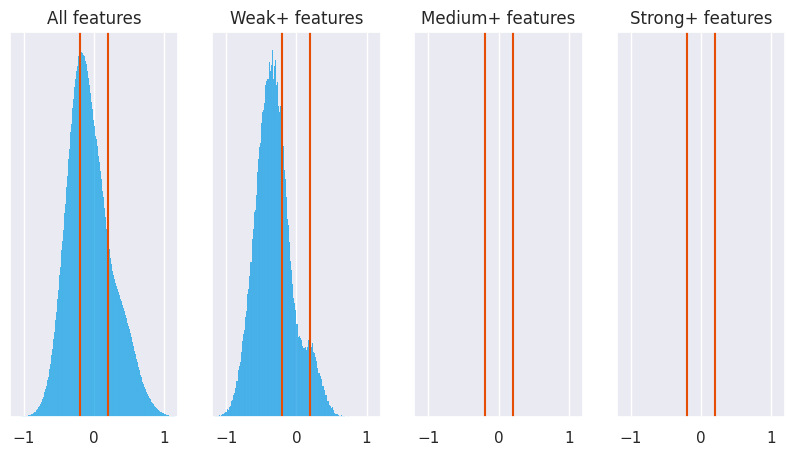

In [60]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 9-12', c_s_i, c_m_i, c_w_i)

338
['Polarity=Neg', 'flat:foreign', 'Number[psor]=Sing', 'Foreign=Yes', 'ADV_To_AUX_Ratio', 'NOUN_Variation_Corrected', 'StackingOfClauses', 'Person[psor]=1', 'Reflex=Yes']
9


<Axes: >

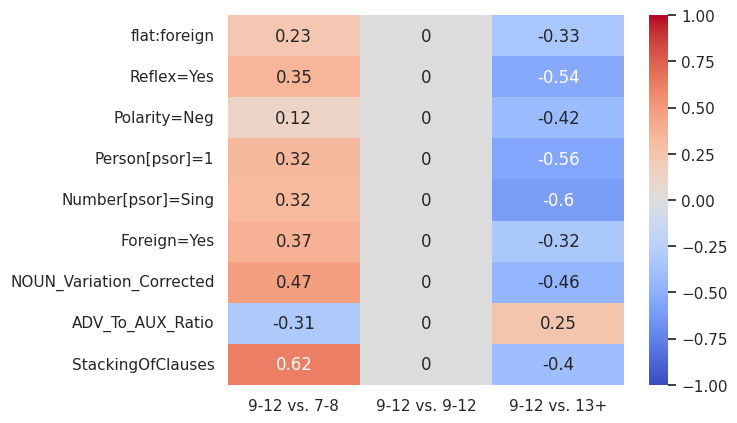

In [61]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
#most_important_2 = c_m_f
most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '9')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Other tests

### Checking if my TTR calculations work (they do, jsut some rounding mishaps)

In [62]:
def testTTR(corpus: dict):
    returnable = {}
    for id in corpus:
        df = corpus[id]
        types = len(df.drop_duplicates(['text'])['text'])
        tokens = len(df)
        returnable[id] = (types/tokens)
    return returnable


In [63]:
new_func = testTTR(corpus)

In [64]:
old_func = fe.getTypeTokenRatios(fe.getColumnFrequencies(corpus, ['text']), fe.getTokenAmounts(corpus))

In [65]:
young = []
mid = []
old = []
for id in new_func:
    if old_func[id] != new_func[id]:
        print("Different!")
        print(id)
        print(old_func[id])
        print(new_func[id])

### Cosine similarities between the means of KFA results (very messy, stay away if you can :D)

In [66]:
windows = ['7','9','1']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [67]:
weak_7to9 = ['vocative', 'CCONJ_PRON_CCONJ', 'PROPN_To_ADP_Ratio', 'xcomp:ds_xcomp:ds', 'acl:relcl_ccomp', 'nmod_acl:relcl', 'obl_nmod:gsubj', 'Reflex=Yes', 'PUNCT_PROPN_CCONJ', 'NOUN_PUNCT_INTJ', 'PRON_AUX_ADP', 'vocative_amod', 'INTJ_To_AUX_Ratio', 'VERB_VERB_PRON', 'INTJ_PUNCT_NOUN', 'PRON_SCONJ', 'acl:relcl_xcomp:ds', 'SCONJ_VERB', 'xcomp_xcomp', 'ccomp', 'xcomp:ds_advcl', 'advmod_xcomp:ds', 'obl_ccomp', 'TTR', 'ADP_ADV_SCONJ', 'ADV_To_SCONJ_Ratio', 'PRON_NOUN_VERB', 'nmod:gsubj', 'root_vocative', 'INTJ_To_SCONJ_Ratio', 'VERB_AUX_VERB', 'PRON_SCONJ_AUX', 'INTJ_To_PRON_Ratio', 'SCONJ_To_ADV_Ratio', 'INTJ_INTJ_ADJ', 'SCONJ_PUNCT_PUNCT', 'PROPN_CCONJ_PROPN', 'Case=Abl', 'AUX_VERB_VERB', 'PRON_PUNCT_CCONJ', 'ccomp_cc', 'VERB_SCONJ_AUX', 'PROPN_PUNCT_INTJ', 'xcomp:ds_ccomp', 'Derivation=Ton', 'INTJ_To_ADV_Ratio', 'InfForm=3', 'INTJ_To_CCONJ_Ratio', 'VERB_PRON_SCONJ', 'INTJ_To_ADP_Ratio', 'VERB_PUNCT_NOUN']
weak_9to13 = ['Number[psor]=Sing', 'flat:name_obj', 'PROPN_AUX_NUM', 'flat:name_flat:foreign', 'PUNCT_VERB', 'flat:name_aux', 'AUX_AUX_PROPN', 'PRON_INTJ', 'ADP_AUX_PRON', 'VERB_AUX_PUNCT', 'Polarity=Neg', 'AUX_PRON_PUNCT', 'PUNCT_VERB_ADJ', 'AUX_AUX_ADJ', 'PUNCT_PRON_INTJ', 'PRON_PUNCT_AUX', 'ADP_ADV_SCONJ', 'VERB_CCONJ_ADJ', 'SCONJ_SCONJ_AUX', 'AUX_PRON_ADJ', 'PUNCT_AUX_AUX', 'PUNCT_AUX', 'PRON_NOUN_CCONJ', 'AUX_PROPN_ADP', 'ADP_AUX_SCONJ', 'PRON_INTJ_PRON', 'ADP_PUNCT_VERB', 'AUX_ADJ_PUNCT']
med_7to13 = ['PRON_NOUN', 'VERB_PRON', 'ccomp_advcl', 'AUX_AUX_VERB', 'PUNCT_SCONJ_AUX', 'Number[psor]=Sing', 'PRON_CCONJ', 'PRON_PRON_PUNCT', 'ADV_To_AUX_Ratio', 'SCONJ_AUX', 'Person=1', 'PRON_CCONJ_PRON', 'acl:relcl_xcomp', 'ccomp_nmod', 'appos_ccomp', 'Reflex=Yes', 'PUNCT_PROPN_CCONJ', 'NOUN_PUNCT_INTJ', 'PRON_PUNCT_SCONJ', 'PUNCT_VERB_PRON', 'AUX_AUX', 'root_ccomp', 'PROPN_VERB_PUNCT', 'PRON_INTJ', 'Derivation=Vs', 'ccomp_amod', 'INTJ_PUNCT_NOUN', 'VERB_VERB_PRON', 'PRON_PUNCT', 'PRON_PUNCT_ADV', 'AUX_To_ADV_Ratio', 'VERB_AUX', 'Polarity=Neg', 'SCONJ_VERB', 'ccomp_xcomp:ds', 'ccomp_nsubj:cop', 'ccomp', 'AUX_VERB_PRON', 'PUNCT_NOUN_PROPN', 'PROPN_To_AUX_Ratio', 'Connegative=Yes', 'AUX_PRON_PUNCT', 'ccomp_obl', 'PUNCT_SCONJ_VERB', 'ADV_VERB_AUX', 'nmod_ccomp', 'conj_aux', 'PUNCT_PRON_INTJ', 'ccomp_mark', 'obl_ccomp', 'CCONJ_AUX', 'PRON_PUNCT_AUX', 'TTR', 'ADV_To_SCONJ_Ratio', 'SCONJ_AUX_ADJ', 'Derivation=Llinen', 'ccomp_cop', 'INTJ_To_SCONJ_Ratio', 'SCONJ_VERB_PRON', 'VERB_AUX_VERB', 'AUX_AUX_PRON', 'CCONJ_AUX_VERB', 'SCONJ_To_ADV_Ratio', 'ccomp_conj', 'ccomp_xcomp', 'Person[psor]=1', 'SCONJ_AUX_ADV', 'ccomp_aux', 'ccomp_advmod', 'PROPN_CCONJ_PROPN', 'SCONJ_AUX_AUX', 'AUX_VERB_VERB', 'NOUN_PRON_PUNCT', 'PROPN_CCONJ', 'PRON_PUNCT_CCONJ', 'PRON_AUX_AUX', 'PRON_PUNCT_PRON', 'PRON_PUNCT_VERB', 'PROPN_To_SCONJ_Ratio', 'xcomp:ds_ccomp', 'AUX_AUX_AUX', 'Derivation=Ton', 'conj_ccomp', 'ccomp_obj', 'parataxis_nsubj', 'VERB_PRON_PUNCT', 'aux', 'SCONJ_AUX_VERB', 'VERB_PRON_CCONJ', 'PRON_INTJ_PRON', 'nsubj_ccomp', 'nmod_acl:relcl']
med_7to9 = ['VERB_AUX_VERB']
comb = list(set(med_7to13))

In [68]:
testing_df_2 = ef_df.copy()
most_important_2 = comb
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)

['nmod_acl:relcl', 'PRON_PUNCT', 'SCONJ_To_ADV_Ratio', 'AUX_AUX_VERB', 'PRON_CCONJ_PRON', 'conj_ccomp', 'SCONJ_AUX_AUX', 'appos_ccomp', 'conj_aux', 'PRON_PUNCT_CCONJ', 'PUNCT_PROPN_CCONJ', 'Polarity=Neg', 'AUX_VERB_VERB', 'PUNCT_SCONJ_VERB', 'PROPN_VERB_PUNCT', 'Person=1', 'ccomp_amod', 'nsubj_ccomp', 'ccomp_mark', 'ADV_VERB_AUX', 'ccomp_nsubj:cop', 'PRON_NOUN', 'nmod_ccomp', 'SCONJ_AUX_ADV', 'Number[psor]=Sing', 'root_ccomp', 'VERB_AUX', 'PRON_PUNCT_VERB', 'PRON_CCONJ', 'SCONJ_VERB_PRON', 'PRON_INTJ_PRON', 'ccomp_advmod', 'NOUN_PUNCT_INTJ', 'aux', 'obl_ccomp', 'NOUN_PRON_PUNCT', 'acl:relcl_xcomp', 'PRON_PRON_PUNCT', 'SCONJ_AUX', 'Connegative=Yes', 'PROPN_CCONJ', 'SCONJ_AUX_VERB', 'VERB_PRON', 'AUX_AUX', 'PUNCT_PRON_INTJ', 'VERB_VERB_PRON', 'ccomp_xcomp:ds', 'xcomp:ds_ccomp', 'AUX_To_ADV_Ratio', 'ccomp', 'SCONJ_AUX_ADJ', 'PROPN_To_SCONJ_Ratio', 'VERB_PRON_CCONJ', 'PRON_AUX_AUX', 'Derivation=Ton', 'ccomp_obj', 'Derivation=Llinen', 'INTJ_PUNCT_NOUN', 'ccomp_conj', 'VERB_PRON_PUNCT', 'cco

In [69]:
temp_1_df = testing_df_edited_2.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [71]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

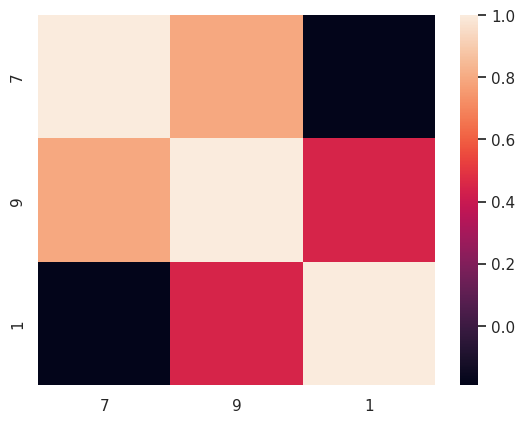

In [72]:
sns.heatmap(matrix_df_2)